In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
# Importing the libraries

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor

%matplotlib inline
sns.set()

In [3]:
# Importing the train and test sets

train_df = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
test_df = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
train = train_df.copy()
test = test_df.copy()
print("Size of training set:", train.shape)
print("Size of testing set:", test.shape)
print("\n\n")
train.head()

Size of training set: (1460, 81)
Size of testing set: (1459, 80)





,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Getting the information and some basic statistics from the training dataset

print(train.describe())
print("\n\n")
print(train.info())

                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ..

# EDA & Visualization

In [5]:
# Functions needed for EDA

def subplot_num(col_num):
    """
    Accepts number of columns (6 or more) for visualization 
    and claculates numbers of subplots required.
    
    Parameters
    ----------
    col_num: Int, number of columns to be visualized
    
    Returns
    ----------
    Two integers first for fig, second for ax
    """
    fig, ax = 0, 0
    
    if col_num > 6:
        fig = (col_num // 6) + 1
        ax = 6
        
    else:
        fig, ax = 1, col_num
    
    return (fig, ax)

def numeric_corr(data, height = 15, width = 15):
    """
    Accpets numerical data and calculates Pearson correlation
    for the variables.
    
    Parameters
    ----------
    data: Pandas dataframe, only including the numerical data
    height: Int, specifies the height of the heatmap. 15 by default
    width: Int, specifies the width of the heatmap. 15 by default
    
    Returns
    ----------
    Seaborn heatmap plot
    """
    mask = np.triu(np.ones_like(data.corr(), dtype = bool))
    plt.figure(dpi = 100, figsize = (height, width))
    plt.title("Pearson Correlation Analysis")
    sns.heatmap(data.corr().round(2), mask = mask, annot = True, lw = 0.1, linecolor = "black",
			cmap = "viridis", annot_kws = {"size": 8})

    # Next line is optional. If the cell size of the geat map are not fit for the text, change it.
    # sns.set(font_scale = 1.1)
    plt.xticks()
    plt.yticks(rotation = 0)
    plt.show()
    

def basic_details(data):
    """
    Accepts data and calculates number of missing values, missing value percentage, Usability
    unique values, data type, skewness and kurtosis for each column.
    
    Parameters
    ----------
    data: Pandas dataframe
    
    Returns
    ----------
    Pands dataframe including seven columns
    """
    res = pd.DataFrame()
    res['Missing Value'] = data.isnull().sum()
    res["Missing Value %"] = ((res["Missing Value"] / len(data)) * 100).round(2)
    res["Usability"] = np.where(res["Missing Value %"] > 15, "Discard", "Keep")
    res['Unique Value'] = data.nunique()
    res['Data Type'] = data.dtypes
    res["Skewness"] = data.skew(numeric_only = True)
    res["Kurtosis"] = data.kurt(numeric_only = True)
    return res  

In [6]:
# Separating numerical and categorical columns

numeric = [x for x in train.columns if train[x].dtypes != "object"]
categoric = [x for x in train.columns if train[x].dtypes == "object"]
target = "SalePrice"

In [7]:
# Deleting Id column from the numeric list

del numeric[0]

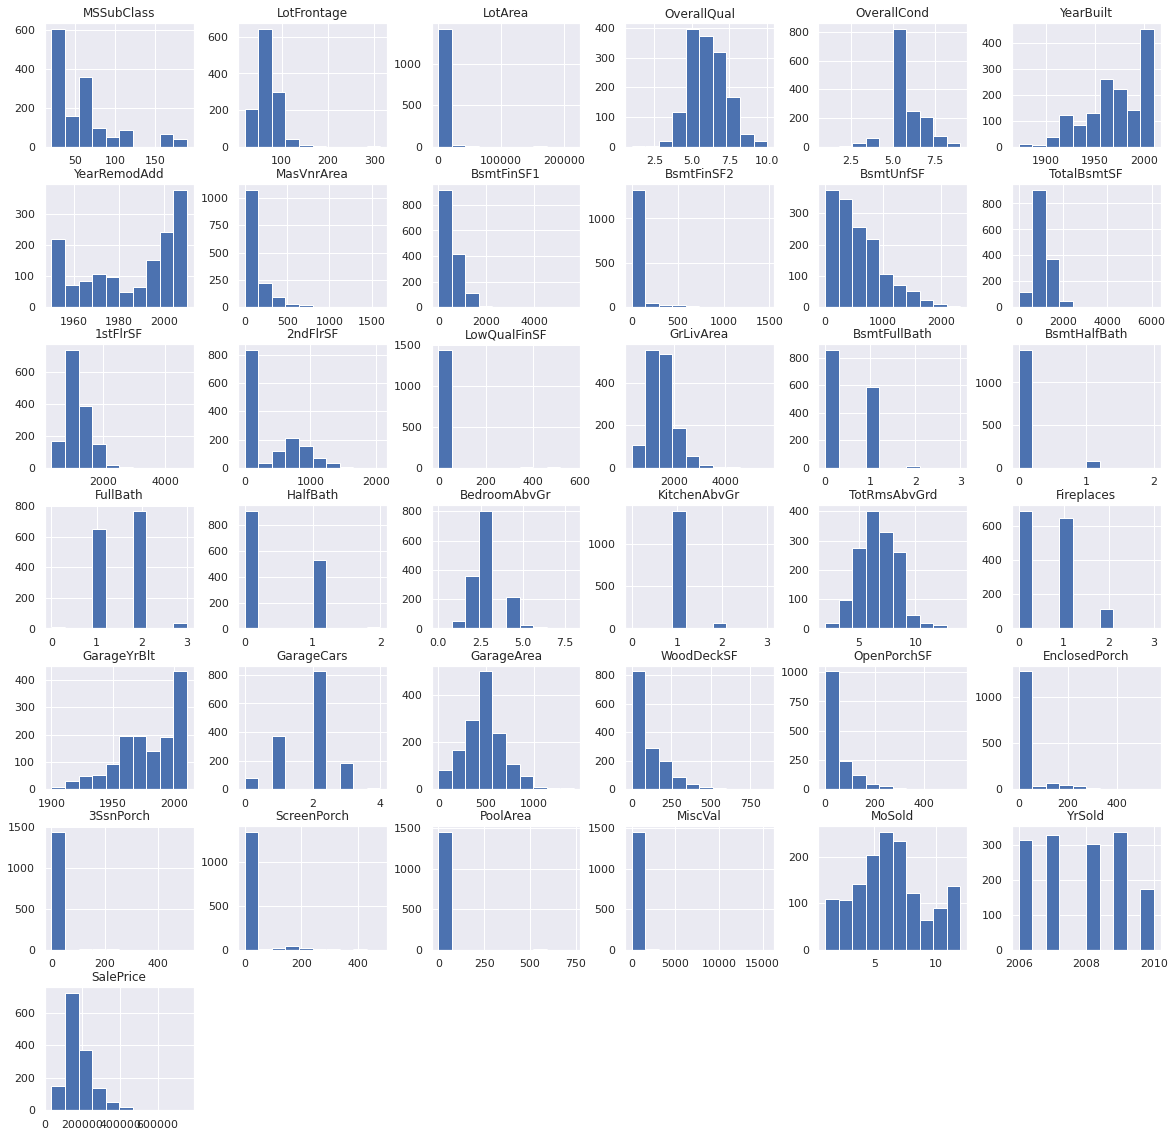

In [8]:
# Visualizing all numeric columns

_ = train[numeric].hist(figsize = (20, 20))

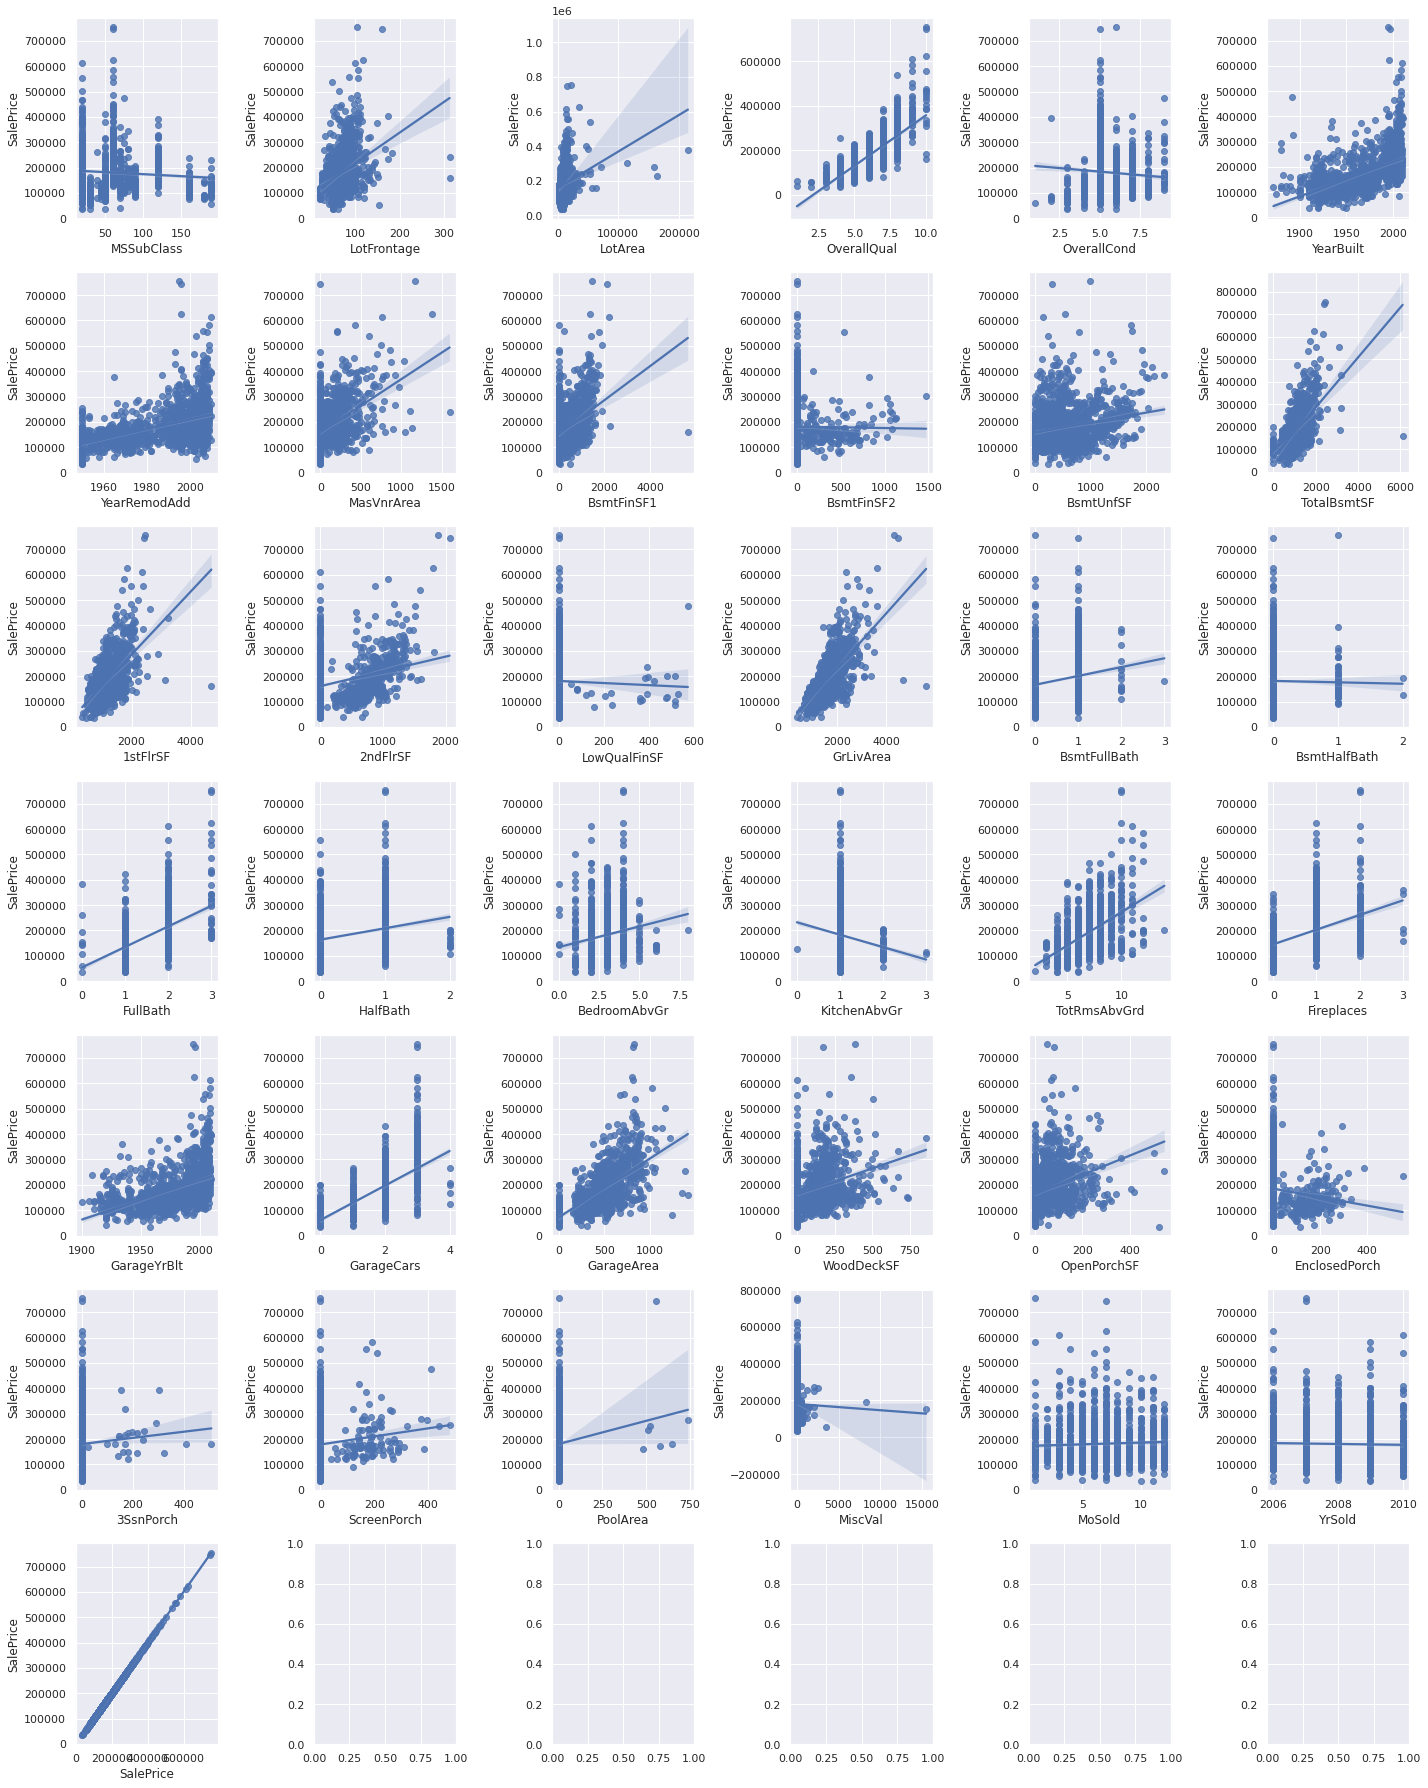

In [9]:
# Discovering if there is a linear relation between the numerical values of the dataset 
#      and the target variable

fig, ax = subplot_num(len(numeric))
fig, axs = plt.subplots(fig, ax, figsize = (20, 25))


for ax, i in zip(axs.flat, range(len(numeric))):
    sns.regplot(x = numeric[i], y = target, data = train[numeric], ax = ax)
    
    
plt.tight_layout()    
plt.show()

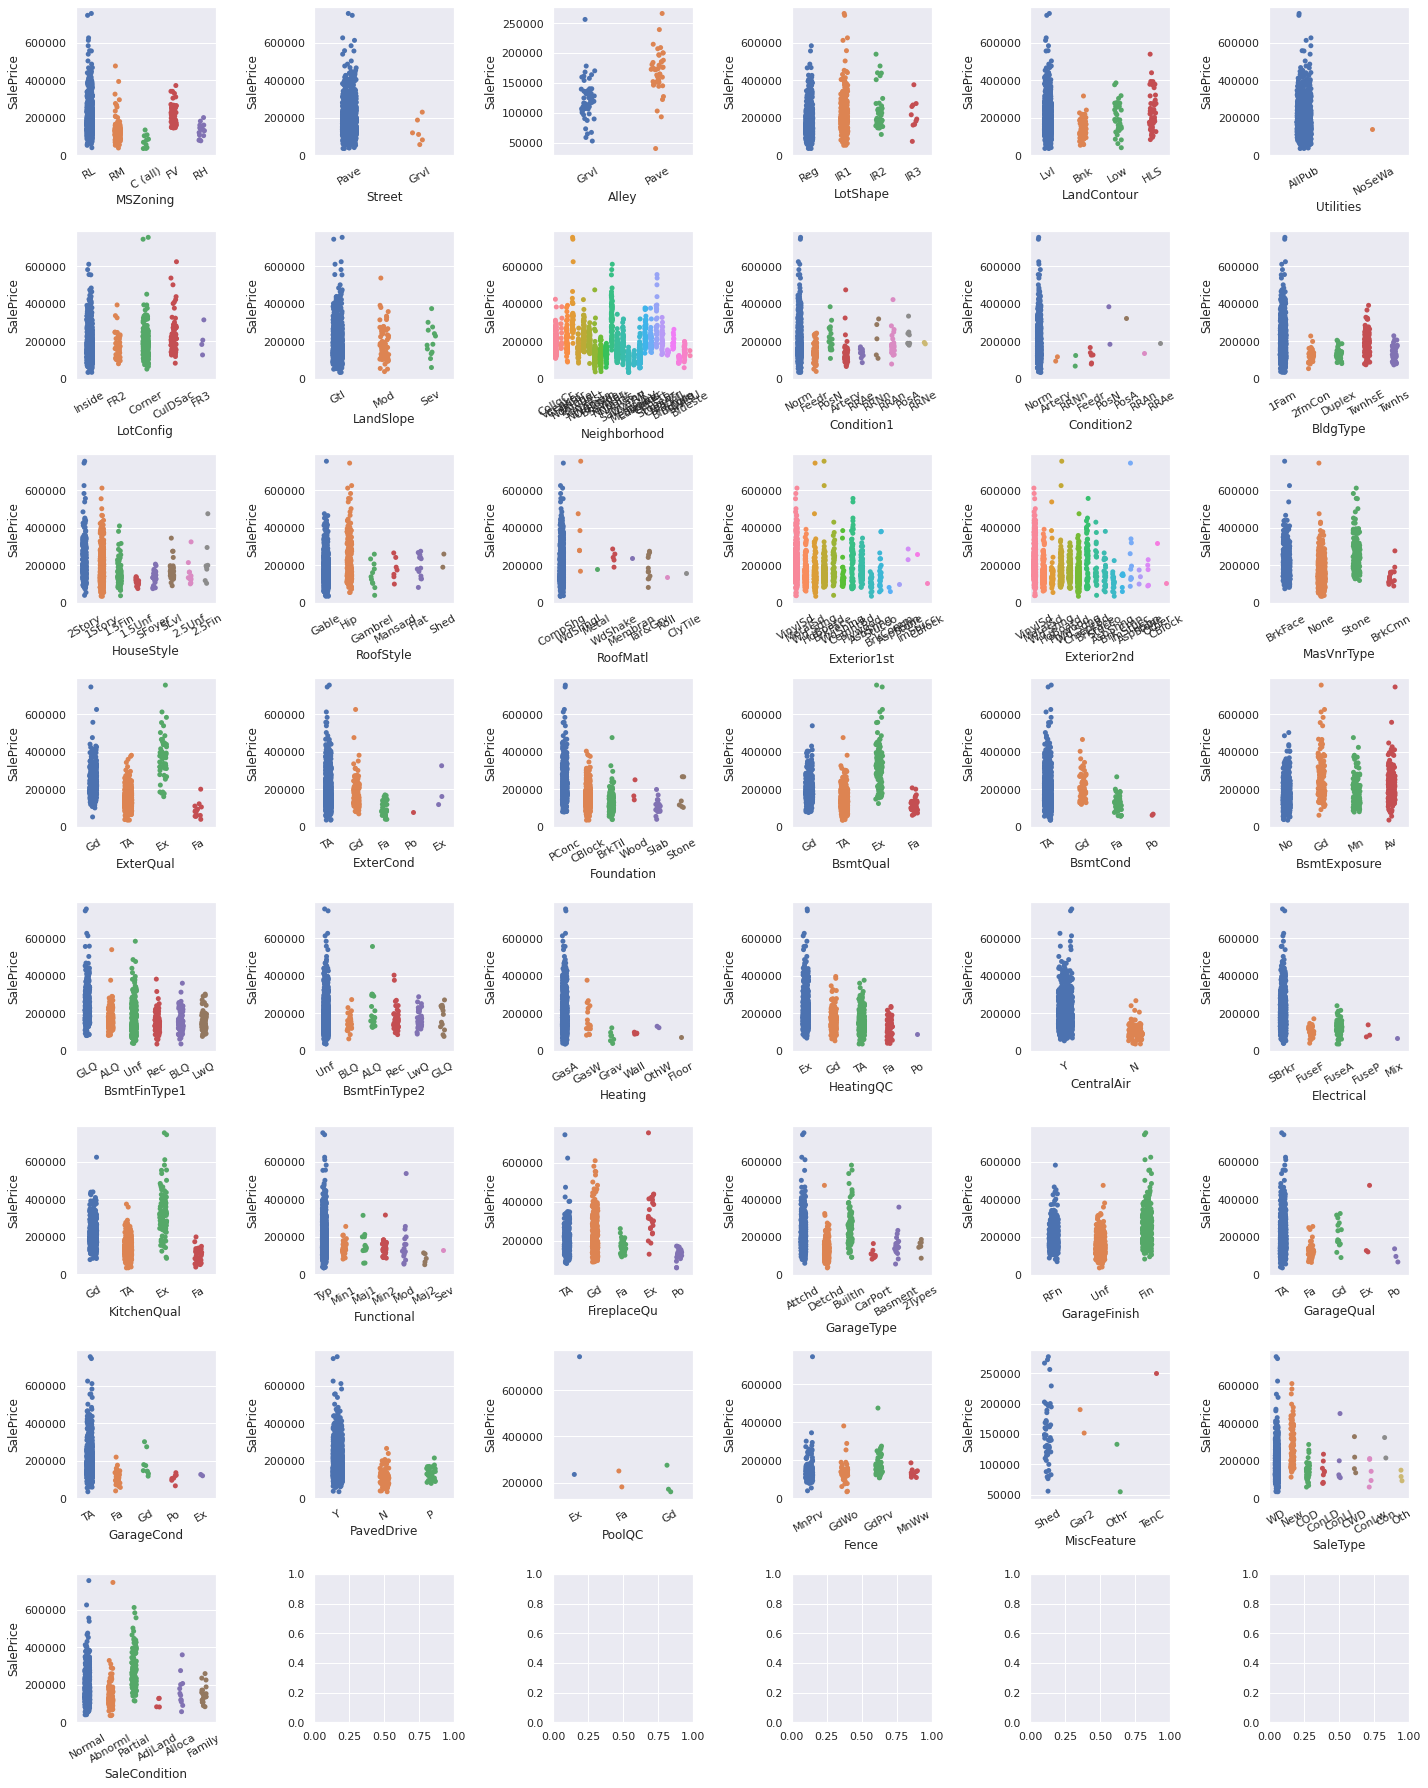

In [10]:
# Visualizing the relation between the categorical variables of the dataset and the target variable

fig, ax = subplot_num(len(categoric))
fig, axs = plt.subplots(fig, ax, figsize = (20, 25))


for ax, i in zip(axs.flat, range(len(categoric))):
    sns.stripplot(x = categoric[i], y = target, data = train, ax = ax, )
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
    
plt.tight_layout()    
plt.show()

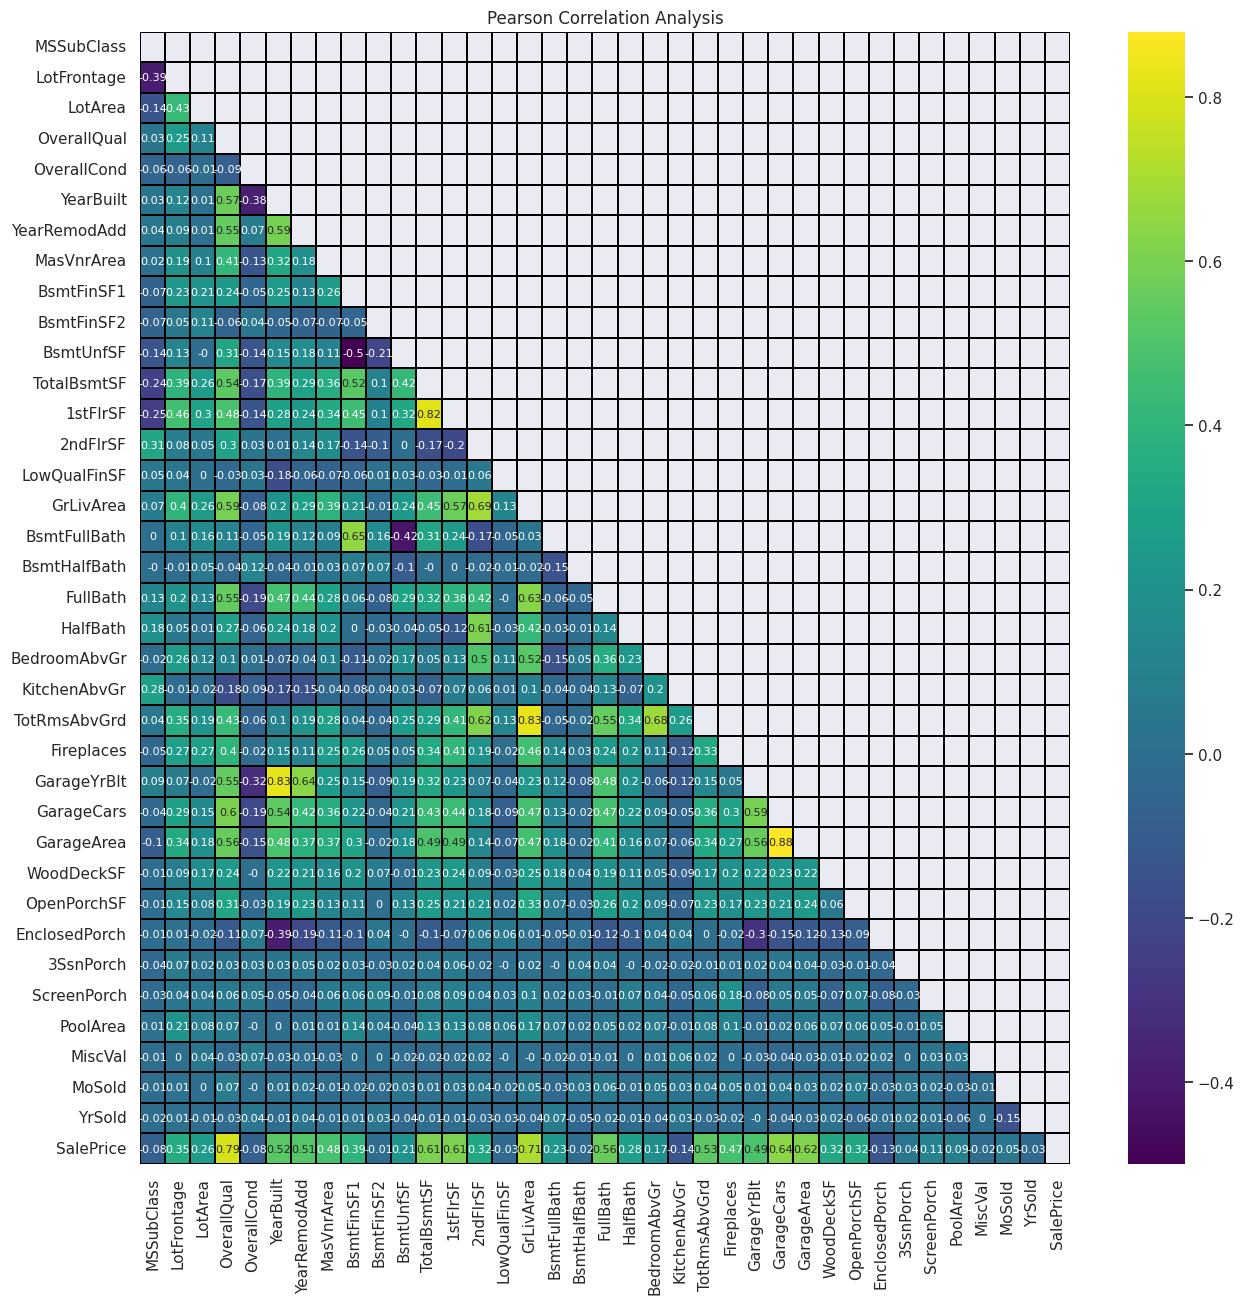

In [11]:
# Visualizing the Pearson correlation between numerical features

numeric_corr(train[numeric])

In [12]:
stats = basic_details(train)
stats.head()

,Missing Value,Missing Value %,Usability,Unique Value,Data Type,Skewness,Kurtosis
Id,0,0.00,Keep,1460,int64,0.000000,-1.200000
MSSubClass,0,0.00,Keep,15,int64,1.407657,1.580188
MSZoning,0,0.00,Keep,5,object,NaN,NaN
LotFrontage,259,17.74,Discard,110,float64,2.163569,17.452867
LotArea,0,0.00,Keep,1073,int64,12.207688,203.243271


# Preprocessing & Feature Engineering

In [13]:
# Functions needed for Preprocessing and Feature Engineering 

def impute_knn(df):
    """
    Accepts data and calculates the missing values for numercial columns uing KNN 
    algorithm with 5 nearest neighbors
    
    Parameters
    ----------
    data: Pandas dataframe
    
    Returns
    ----------
    Pandas dataframe
    """
    num_in = df.select_dtypes(include=[np.number])
    num_ex = df.select_dtypes(exclude=[np.number])

    cols_nan = num_in.columns[num_in.isna().any()].tolist()         # columns w/ nan 
    cols_no_nan = num_in.columns.difference(cols_nan).values     # columns w/n nan

    for col in cols_nan:
        imp_test = num_in[num_in[col].isna()]   # indicies which have missing data will become our test set
        imp_train = num_in.dropna()          # all indicies which which have no missing data 
        model = KNeighborsRegressor(n_neighbors = 5)  # KNN Unsupervised Approach
        knn = model.fit(imp_train[cols_no_nan], imp_train[col])
        num_in.loc[num_in[col].isna(), col] = knn.predict(imp_test[cols_no_nan])
    
    return pd.concat([num_in, num_ex], axis = 1)


In [14]:
# For this part, it is requred to apply changes to both train and test dataset
# Thus, the two dataframes are concatenated into one in order to avoid doing anything twice

two_df = pd.concat([train, test], axis = 0, sort = False)

# Converting non-numeric columns stored as numbers into string

two_df['MSSubClass'] = two_df['MSSubClass'].apply(str)
two_df['YrSold'] = two_df['YrSold'].apply(str)
two_df['MoSold'] = two_df['MoSold'].apply(str)

# Filling Categorical NaN According to the Description File 

two_df['Functional'] = two_df['Functional'].fillna('Typ')
two_df['Electrical'] = two_df['Electrical'].fillna("SBrkr")
two_df['KitchenQual'] = two_df['KitchenQual'].fillna("TA")


for col in ['Exterior1st', 'Exterior2nd', 'SaleType']:
    two_df[col] = two_df[col].fillna(two_df[col].mode()[0])
    
for col in ['GarageArea', 'GarageCars']:
    two_df[col] = two_df[col].fillna(0)
        
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
           'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
           'MiscFeature', 'Fence', 'FireplaceQu', "Alley", "PoolQC"]:
    two_df[col] = two_df[col].fillna('None')

In [15]:
drop_cols = ['GarageYrBlt','YearRemodAdd', "Id", "SalePrice"] 
final = two_df.drop(drop_cols, axis = 1)
y_train = train["SalePrice"]
stats = basic_details(final)
stats.head()

,Missing Value,Missing Value %,Usability,Unique Value,Data Type,Skewness,Kurtosis
MSSubClass,0,0.00,Keep,16,object,NaN,NaN
MSZoning,4,0.14,Keep,5,object,NaN,NaN
LotFrontage,486,16.65,Discard,128,float64,1.503278,11.295921
LotArea,0,0.00,Keep,1951,int64,12.829025,264.952310
Street,0,0.00,Keep,2,object,NaN,NaN


In [16]:
stats[(stats["Usability"] == "Discard") | (stats["Missing Value"] > 0)]

,Missing Value,Missing Value %,Usability,Unique Value,Data Type,Skewness,Kurtosis
MSZoning,4,0.14,Keep,5,object,NaN,NaN
LotFrontage,486,16.65,Discard,128,float64,1.503278,11.295921
Utilities,2,0.07,Keep,2,object,NaN,NaN
MasVnrType,24,0.82,Keep,4,object,NaN,NaN
MasVnrArea,23,0.79,Keep,444,float64,2.602589,9.254343
BsmtFinSF1,1,0.03,Keep,991,float64,1.425722,6.904832
BsmtFinSF2,1,0.03,Keep,272,float64,4.147456,18.836540
BsmtUnfSF,1,0.03,Keep,1135,float64,0.919824,0.403617
TotalBsmtSF,1,0.03,Keep,1058,float64,1.162882,9.151099
BsmtFullBath,2,0.07,Keep,4,float64,0.624062,-0.735693


In [17]:
two_total = impute_knn(final)
two_total_res = basic_details(two_total)
two_total_res[two_total_res["Missing Value"] > 0]

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

,Missing Value,Missing Value %,Usability,Unique Value,Data Type,Skewness,Kurtosis
MSZoning,4,0.14,Keep,5,object,NaN,NaN
Utilities,2,0.07,Keep,2,object,NaN,NaN
MasVnrType,24,0.82,Keep,4,object,NaN,NaN


In [18]:
# Imputing the rest of the columns

objects = []
for col in two_total.columns:
    if two_total[col].dtype == object:
        objects.append(col)
        
two_total.update(two_total[objects].fillna('None'))

In [19]:
two_total_dummy = pd.get_dummies(two_total)
high_skew = two_total_res[two_total_res["Skewness"] > 0.5]
skew_index = high_skew.index
    
for i in skew_index:
    two_total_dummy[i] = np.log1p(two_total_dummy[i])

In [20]:
x_train = two_total_dummy[:len(y_train)]
x_test = two_total_dummy[len(y_train):]

In [21]:
x_test.shape , x_train.shape

((1459, 332), (1460, 332))

# Modeling

In [22]:
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'subsample': [0.45, 0.5, 0.55], 'n_estimators': [1200, 1400], 
     'max_depth': [5], 'learning_rate': [0.02],
     'colsample_bytree': [0.4], 'colsample_bylevel': [0.5],
     'reg_alpha':[1], 'reg_lambda': [1], 'min_child_weight':[2]}
]

xgb_model = XGBRegressor(eval_metric = 'rmse')

grid_search = GridSearchCV(
    xgb_model,
    param_grid = param_grid,
    scoring = 'neg_root_mean_squared_error',
    n_jobs = 10,
    cv = 5,
    verbose = True
)

grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_c...
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None, ...),
             n_jobs=10,
             

In [23]:
y_predict = np.floor(np.expm1(grid_search.best_estimator_.predict(x_test)))
sub = pd.DataFrame()
sub['Id'] = test["Id"]
sub['SalePrice'] = y_predict
sub.to_csv('./submission.csv',index = False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in expm1
  """Entry point for launching an IPython kernel.
